In [2]:
import numpy as np
import scipy as sp
import qibo
from qibo.symbols import *
from qibo import hamiltonians
import matplotlib.pyplot as plt
from tqdm import tqdm



In [3]:
def createPauliString(nsites, position, symbols):
    pauliString = ""
    for i in range(nsites):
        if i not in position:
            pauliString += "I"
        else:
            pauliString += symbols[position.index(i)]

    return pauliString

def pauliStr2Matrix(str):
    I = np.eye(2)
    X = np.array([[0, 1], [1, 0]])
    Y = np.array([[0, -1j], [1j, 0]])
    Z = np.array([[1, 0], [0, -1]])
    
    if str[0] == 'I':
        mat = I
    elif str[0] == 'X':
        mat = X
    elif str[0] == 'Y':
        mat = Y
    elif str[0] == 'Z':
        mat = Z

    for i in range(len(str)-1):
        if str[i+1] == 'I':
            mat = np.kron(mat, I)
        elif str[i+1] == 'X':
            mat = np.kron(mat, X)
        elif str[i+1] == 'Y':
            mat = np.kron(mat, Y)
        elif str[i+1] == 'Z':
            mat = np.kron(mat, Z)
    
    return mat

def number2Spin(nsites, number):
    spin = np.empty(nsites, dtype=object)
    binary = format(number, f'0{nsites}b')
    for i in range(nsites):
        if binary[i] == '0':
            spin[i] = "up"
        else:
            spin[i] = "down"
    return spin

def thermalState(beta, H):
    rho = sp.linalg.expm(-beta * H)
    rho = rho / np.trace(rho)
    return rho

def freeEnergyExact(beta, H):
    rho = sp.linalg.expm(-beta * H)
    Z = np.trace(rho)
    F = -np.log(Z) / beta
    return F

def computeExpectationValue(rho, operator):
    return np.real(np.trace(rho@operator))

def computeExpectationValueState(state, operator):
    return np.real(np.vdot(state, operator@state))



In [4]:
def jordan_wigner_tfim(n_sites, Jx=1.0, Jy=1.0, h=1.0):
    """
    Construct the Bogoliubov-de Gennes matrix for  Ising model:

    Args:
        n_sites (int): Number of sites
        Jx (float): Coupling strength for σ^x σ^x interaction
        Jy (float): Coupling strength for σ^y σ^y interaction
        h (float): Transverse field strength

    Returns:
        numpy.ndarray: 2n_sites × 2n_sites BdG matrix
    """
    J = Jx + Jy
    k = (Jx - Jy) / J
    A = np.zeros((n_sites, n_sites))
    B = np.zeros((n_sites, n_sites))

    for i in range(n_sites-1):
        A[i, i] = h
        A[i+1, i+1] = h

    # The X terms become nearest-neighbor hopping
    for i in range(n_sites-1):
        A[i, i+1] = A[i+1, i] = -J/2


    for i in range(n_sites-1):
        B[i, i+1] = -J*k/2
        B[i+1, i] = J*k/2

    # Construct BdG matrix
    M = np.block([
        [A, B],
        [-B, -A]
    ])

    return M

def diagonalize_bdg_matrix(M):
    """
    Diagonalize the Bogoliubov-de Gennes matrix to find single-particle energies.
    """
    # Diagonalize the BdG matrix
    eigenvalues, eigenvectors = np.linalg.eigh(M)

    # The eigenvalues come in pairs (ε, -ε)
    # We only need the positive ones for the fermionic spectrum
    n = len(eigenvalues) // 2
    energies = eigenvalues[n:]  # Take the positive eigenvalues

    return energies, eigenvectors

def fermi_dirac(E, beta):
    return 1 / (1 + np.exp(beta * E))

def free_energy(M, beta):
    """
    Compute the free energy of the system from the BdG matrix.

    Args:
        M (numpy.ndarray): 2N × 2N BdG matrix
        beta (float): Inverse temperature (1/T)

    Returns:
        float: Free energy F = -1/β ∑ log(2 cosh(β ε_k))
    """
    eigvals = np.linalg.eigvalsh(M)
    F = - (1 / (2*beta)) * np.sum(np.log(2* np.cosh(beta * eigvals)))
    return F


In [ ]:
def zz_correlation(M, beta, i, j):
    N = M.shape[0] // 2
    eigvals, eigvecs = np.linalg.eigh(M)

    f = 1 / (np.exp(2*beta * eigvals) + 1)  
    f_diag = np.diag(f)

    Uk = eigvecs[:N, :]
    Vk = eigvecs[N:, :]

    G = Uk @ f_diag @ Uk.T
    F = Uk @ f_diag @ Vk.T

    zz = 4*(G[i,i]-0.5)*(G[j,j]-0.5) - 4*G[i,j]*G[j,i] + 4*np.abs(F[i,j])**2

    return zz

# def zz_correlation_dynamic(M, beta, i, j, t):
#     N = M.shape[0] // 2
#     eigvals, eigvecs = np.linalg.eigh(M)

#     f = 1 / (np.exp(2*beta * eigvals) + 1)  
#     f_diag = np.diag(f)

#     Uk = eigvecs[:N, :]
#     Vk = eigvecs[N:, :]

#     # Time evolution in the diagonal basis: exp(-2i t eigvals)
#     U_t = np.diag(np.exp(-2j * t * eigvals))
#     U_t_dag = np.diag(np.exp(2j * t * eigvals))

#     # Time-evolved G(t) and F(t)
#     Gt = Uk @ U_t @ f_diag @ U_t_dag @ Uk.T
#     Ft = Uk @ U_t @ f_diag @ U_t_dag @ Vk.T

#     # Static G(0)
#     G0 = Uk @ f_diag @ Uk.T

#     # Dynamical ZZ correlation function
#     zz = 4*(Gt[i,i]-0.5)*(G0[j,j]-0.5) - 4*Gt[i,j]*G0[j,i] + 4*np.abs(Ft[i,j])**2

#     return zz.real  # The imaginary part should vanish for Hermitian dynamics

def zz_correlation_dynamic(M, beta, i, j, t, h_bar=1.0):
    """
    Compute the thermal dynamical ZZ correlation <Z_i(t)Z_j(0)>_T for the TFIM model.
    
    Parameters:
    -----------
    M : numpy.ndarray
        The Hamiltonian matrix
    beta : float
        Inverse temperature (1/k_B*T)
    i, j : int
        Indices for correlation computation
    t : float
        Time for the dynamical correlation
    h_bar : float, optional
        Planck's constant (default=1.0, for natural units)
        
    Returns:
    --------
    float
        The dynamical ZZ correlation at time t and temperature 1/beta
    """
    N = M.shape[0] // 2
    
    # Diagonalize the Hamiltonian
    eigvals, eigvecs = np.linalg.eigh(M)
    
    # Compute Fermi-Dirac distribution
    f = 1 / (np.exp(2*beta * eigvals) + 1)
    
    Uk = eigvecs[:N, :]
    Vk = eigvecs[N:, :]
    
    # Time evolution factors
    # Note: eigvals are energies, so e^{-iEt/ħ} gives time evolution
    time_evolution = np.exp(-2j * eigvals * t / h_bar)
    
    # For <Z_i(t)Z_j(0)>_T, we need to evolve the operators in time
    
    G_00 = Uk @ np.diag(f) @ Uk.T
    
    # # Time-evolved correlators
    # # We evolve U and V with the time evolution operator
    Uk_t = Uk @ np.diag(np.exp(-2j * eigvals * t / h_bar))
    Vk_t = Vk * time_evolution
    
    
    # Compute the necessary time-dependent Green's functions
    G_t_0 = Uk_t @ np.diag(f) @ Uk.T.conj()
    G_0_t = Uk @ np.diag(f) @ Uk_t.T.conj()
    F_t_0 = Uk_t @ np.diag(f) @ Vk.T.conj()
    G_tt = Uk_t @ np.diag(f) @ Uk_t.T.conj()
    
    
    
    zz_t = 4*(G_tt[i,i]-0.5)*(G_00[j,j]-0.5) - 4*G_t_0[i,j]*G_0_t[j,i] + 4*np.abs(F_t_0[i,j])**2
    return zz_t

def z_dynamic(M, beta, i, t):
    """
    Compute the dynamical Z_i(t) operator for the TFIM model.
    
    Parameters:
    -----------
    M : numpy.ndarray
        The Hamiltonian matrix
    beta : float
        Inverse temperature (1/k_B*T)
    i : int
        Index for the Z operator
    t : float
        Time for the dynamical correlation
    
    Returns:
    --------
    float
        The dynamical Z_i(t) operator at time t and temperature 1/beta
    """
    N = M.shape[0] // 2
    
    # Diagonalize the Hamiltonian
    eigvals, eigvecs = np.linalg.eigh(M)
    
    # Compute Fermi-Dirac distribution
    f = 1 / (np.exp(2*beta * eigvals) + 1)
    
    Uk = eigvecs[:N, :]
    
    # Time evolution factors
    time_evolution = np.exp(-1j * eigvals * t)
    Uk = Uk @ np.diag(time_evolution)
    
    # Evolve the Z operator in time
    Z_t = Uk @ np.diag(f) @ Uk.T.conj()
    
    return 2*(Z_t[i,i]-0.5)


[Qibo 0.2.17|INFO|2025-05-08 14:18:27]: Using numpy backend on /CPU:0
[Qibo 0.2.17|WARNING|2025-05-08 14:18:27]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
C:\Users\andre\AppData\Local\Temp\ipykernel_48532\2162002314.py:56: RuntimeWarning: divide by zero encountered in scalar divide
  F = -np.log(Z) / beta
C:\Users\andre\AppData\Local\Temp\ipykernel_48532\2162002314.py:56: RuntimeWarning: invalid value encountered in scalar divide
  F = -np.log(Z) / beta
C:\Users\andre\AppData\Local\Temp\ipykernel_48532\3328194574.py:24: ComplexWarning: Casting complex values to real discards the imaginary part
  freeEnergy[i] = freeEnergyExact(beta[i], H)
C:\Users\andre\AppData\Local\Temp\ipykernel_48532\1881016336.py:69: RuntimeWarning: divide by zero encountered in scalar divide
  F = - (1 / (2*beta)) * np.sum(np.log(2* np.cosh(beta * eigvals)))


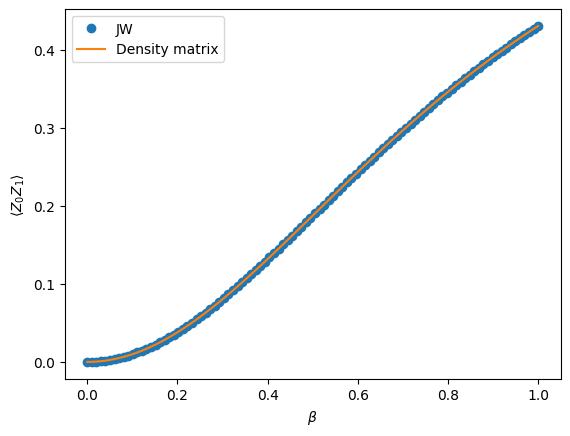

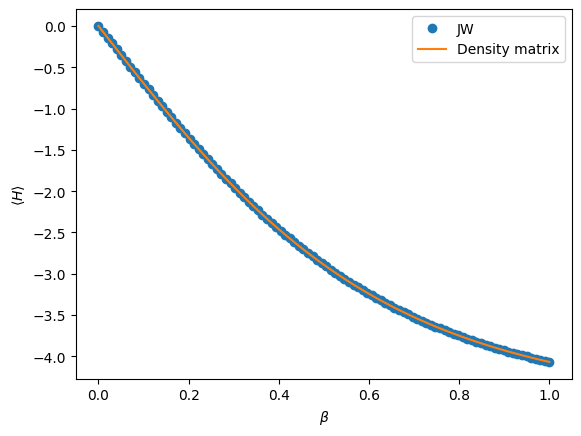

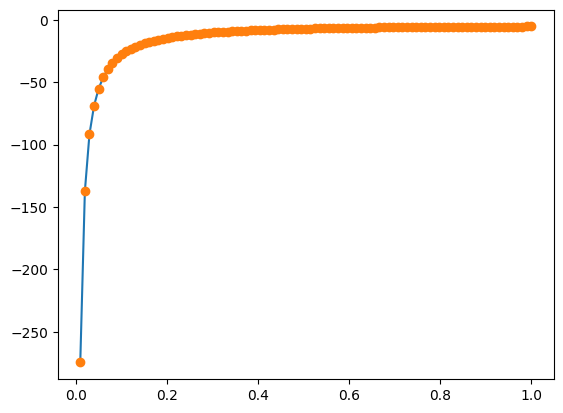

In [6]:
nqubits = 4
# J = 1.0
# h = 1.0
# H_def = sum([-J*X(x)*X(x+1) - h*Z(x) for x in range(nqubits-1)])  - h*Z(nqubits-1)
# H = hamiltonians.SymbolicHamiltonian(H_def).matrix

Jx = 1.0
Jy = 0.0
h = 1.0
H_def = sum([-Jx*X(x)*X(x+1)-Jy*Y(x)*Y(x+1) - h*Z(x) for x in range(nqubits-1)]) - h*Z(nqubits-1) 
H = hamiltonians.SymbolicHamiltonian(H_def).matrix


beta = np.linspace(0, 1, 100)
expectations = np.zeros(len(beta))
freeEnergy = np.zeros(len(beta))
energy_rho = np.zeros(len(beta))

for i in range(len(beta)):
    rho = thermalState(beta[i], H)
    operator = pauliStr2Matrix(createPauliString(nqubits, [0,1], ['Z','Z']))
    expectations[i] = computeExpectationValue(rho, operator)
    energy_rho[i] = computeExpectationValue(rho, H)
    freeEnergy[i] = freeEnergyExact(beta[i], H)

nSites = nqubits


M = jordan_wigner_tfim(nSites, Jx, Jy, h)

energies, eigenvectors = diagonalize_bdg_matrix(M) 

corr = np.zeros(len(beta))
energy = np.zeros(len(beta))
freeEnergy2 = np.zeros(len(beta))
for i in range(len(beta)):
    corr[i] = zz_correlation(M, beta[i], 0, 1)
    n_k = fermi_dirac(2*energies, beta[i])
    energy[i] = np.sum(energies * (2*n_k-1))
    freeEnergy2[i] = free_energy(M, beta[i])

plt.figure()
plt.plot(beta, corr, 'o', label = 'JW')
plt.plot(beta, expectations, label = 'Density matrix')
plt.xlabel(r'$\beta$')
plt.ylabel(r'$\langle Z_{0} Z_{1} \rangle$')
plt.legend()

plt.figure()
plt.plot(beta, energy, 'o' , label = 'JW')
plt.plot(beta, energy_rho , label = 'Density matrix')
plt.xlabel(r'$\beta$')
plt.ylabel(r'$\langle H \rangle$')
plt.legend()
plt.show()

plt.figure()
plt.plot(beta, freeEnergy, label = 'Density matrix')
plt.plot(beta, freeEnergy2, 'o', label = 'JW')


[Qibo 0.2.17|WARNING|2025-05-12 11:46:03]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
C:\Users\andre\AppData\Local\Temp\ipykernel_23024\2364837883.py:32: ComplexWarning: Casting complex values to real discards the imaginary part
  dynamicCorrelationTFIM[i] = z_dynamic(M, beta, 0, t[i])


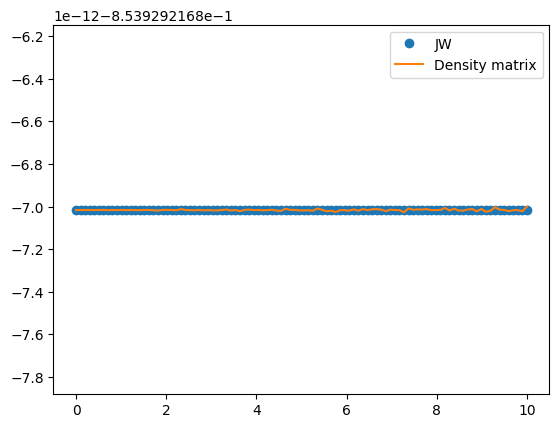

In [122]:
nqubits = 6
# J = 1.0
# h = 1.0
# H_def = sum([-J*X(x)*X(x+1) - h*Z(x) for x in range(nqubits-1)])  - h*Z(nqubits-1)
# H = hamiltonians.SymbolicHamiltonian(H_def).matrix

Jx = 1.0
Jy = 0.0
h = 1.0
H_def = sum([-Jx*X(x)*X(x+1)-Jy*Y(x)*Y(x+1) - h*Z(x) for x in range(nqubits-1)]) - h*Z(nqubits-1) 
H = hamiltonians.SymbolicHamiltonian(H_def).matrix
nSites = nqubits
M = jordan_wigner_tfim(nSites, Jx, Jy, h)


t = np.linspace(0, 10, 100)

dynamicCorrelationExact = np.zeros((len(t)))
dynamicCorrelationTFIM = np.zeros((len(t)))
beta = 10
for i in range(len(t)):
    rho = thermalState(beta, H)
    
    operator = pauliStr2Matrix(createPauliString(nqubits, [0], ['Z']))
    operatorEvolved = sp.linalg.expm(-1j*t[i]*H) @ operator @ sp.linalg.expm(1j*t[i]*H)
    #operator2 = pauliStr2Matrix(createPauliString(nqubits, [1], ['Z']))
    observable = operatorEvolved #@ operator2
    dynamicCorrelationExact[i] = computeExpectationValue(rho, observable)


for i in range(len(t)):
    dynamicCorrelationTFIM[i] = z_dynamic(M, beta, 0, t[i])

plt.figure()
plt.plot(t, dynamicCorrelationTFIM, 'o', label = 'JW')
plt.plot(t, -dynamicCorrelationExact, label = 'Density matrix')
plt.legend()






[Qibo 0.2.17|WARNING|2025-05-12 11:46:06]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.


TypeError: Input z must be 2D, not 1D

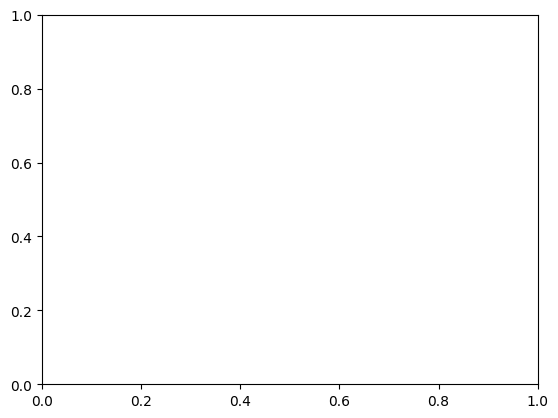

In [123]:
nqubits = 4
# J = 1.0
# h = 1.0
# H_def = sum([-J*X(x)*X(x+1) - h*Z(x) for x in range(nqubits-1)])  - h*Z(nqubits-1)
# H = hamiltonians.SymbolicHamiltonian(H_def).matrix

Jx = 1.0
Jy = 0.0
h = 1.0
H_def = sum([-Jx*X(x)*X(x+1)-Jy*Y(x)*Y(x+1) - h*Z(x) for x in range(nqubits-1)]) - h*Z(nqubits-1) 
H = hamiltonians.SymbolicHamiltonian(H_def).matrix
nSites = nqubits
M = jordan_wigner_tfim(nSites, Jx, Jy, h)


beta = np.linspace(0, 1, 100)

dynamicCorrelationExact = np.zeros((len(beta)))
dynamicCorrelationTFIM = np.zeros((len(beta)))

# for i in range(len(beta)):
#     rho = thermalState(beta[i], H)
#     for j in range(len(t)):
#         operator = pauliStr2Matrix(createPauliString(nqubits, [0], ['Z']))
#         operatorEvolved = sp.linalg.expm(-1j*t[j]*H) @ operator @ sp.linalg.expm(1j*t[j]*H)
#         operator2 = pauliStr2Matrix(createPauliString(nqubits, [1], ['Z']))
#         observable = operatorEvolved @ operator2
#         dynamicCorrelationExact[i,j] = computeExpectationValue(rho, observable)
    
for i in range(len(beta)):
    rho = thermalState(beta[i], H)
    
    operator = pauliStr2Matrix(createPauliString(nqubits, [0], ['Z']))
    operatorEvolved = sp.linalg.expm(-1j*H) @ operator @ sp.linalg.expm(1j*H)
    operator2 = pauliStr2Matrix(createPauliString(nqubits, [1], ['Z']))
    observable = operatorEvolved @ operator2
    dynamicCorrelationExact[i] = computeExpectationValue(rho, observable)

plt.figure()
plt.contourf(t, beta, dynamicCorrelationExact, levels=100)
plt.colorbar()
plt.xlabel(r'$t$')
plt.ylabel(r'$\beta$')
plt.show()


for i in range(len(beta)):
    for j in range(len(t)):
        dynamicCorrelationTFIM[i,j] = zz_correlation_dynamic(M, beta[i], 1, 0, t[j])
plt.figure()
plt.contourf(t, beta, dynamicCorrelationTFIM, levels=100)
plt.colorbar()
plt.xlabel(r'$t$')
plt.ylabel(r'$\beta$')
plt.show()


# 
# energies, eigenvectors = diagonalize_bdg_matrix(M) 

# corr = np.zeros(len(beta))
# energy = np.zeros(len(beta))
# freeEnergy2 = np.zeros(len(beta))
# for i in range(len(beta)):
#     corr[i] = zz_correlation(M, beta[i], 0, 1)
#     n_k = fermi_dirac(2*energies, beta[i])
#     energy[i] = np.sum(energies * (2*n_k-1))
#     freeEnergy2[i] = free_energy(M, beta[i])

# plt.figure()
# plt.plot(beta, corr, 'o', label = 'JW')
# plt.plot(beta, expectations, label = 'Density matrix')
# plt.xlabel(r'$\beta$')
# plt.ylabel(r'$\langle Z_{0} Z_{1} \rangle$')
# plt.legend()

# plt.figure()
# plt.plot(beta, energy, 'o' , label = 'JW')
# plt.plot(beta, energy_rho , label = 'Density matrix')
# plt.xlabel(r'$\beta$')
# plt.ylabel(r'$\langle H \rangle$')
# plt.legend()
# plt.show()

# plt.figure()
# plt.plot(beta, freeEnergy, label = 'Density matrix')
# plt.plot(beta, freeEnergy2, 'o', label = 'JW')


In [7]:
def exactSeriesExpansion(N, H, order, beta):
    Z = 0
    for i in range(0,order+1):
        Z += ((-1)**i*(beta)**i/sp.special.factorial(i))*np.trace(np.linalg.matrix_power(H, i))
    return Z

def expectationSeries(O, H, beta, order):
    E = 0
    for i in range(0,order+1):
        E += ((-1)**i*(beta)**i/sp.special.factorial(i))*np.trace(np.linalg.matrix_power(H, i)@O)
    return E


[Qibo 0.2.17|WARNING|2025-04-29 13:35:21]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.17|WARNING|2025-04-29 13:35:21]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.17|WARNING|2025-04-29 13:35:21]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.17|WARNING|2025-04-29 13:35:21]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.


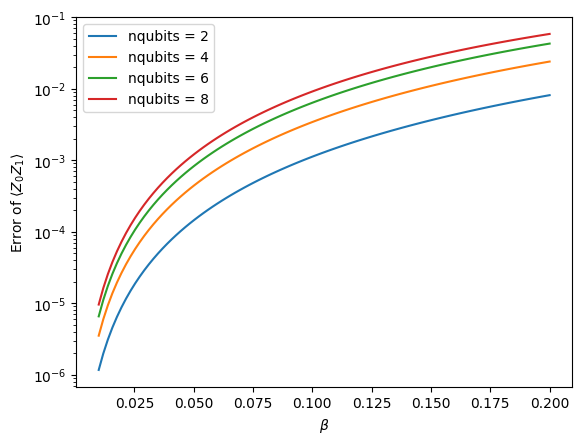

In [19]:
nqubits = [2,4,6,8]

plt.figure()
for nqubits in nqubits:

    H_def = sum([X(x)*X(x+1) + Y(x)*Y(x+1)+Z(x)*Z(x+1) for x in range(nqubits-1)])
    H = hamiltonians.SymbolicHamiltonian(H_def).matrix
    beta = np.linspace(0.01, 0.2, 100)
    Obs = pauliStr2Matrix(createPauliString(nqubits, [0,1], ['Z','Z']))

    expectationExact = np.zeros(len(beta))
    expectationApprox = np.zeros(len(beta))
    
    for i in range(len(beta)):
        rho = thermalState(beta[i], H)
        expectationExact[i] = computeExpectationValue(rho, Obs)
        expectationApprox[i] = (-beta[i]-beta[i]**2)/(1+3/2*beta[i]**2*(nqubits-1))

    plt.plot(beta, np.abs(expectationExact-expectationApprox), label = f'nqubits = {nqubits}')
    plt.xlabel(r'$\beta$')
    plt.ylabel(r'Error of $\langle Z_{0} Z_{1} \rangle$')
    plt.yscale('log')
plt.legend()

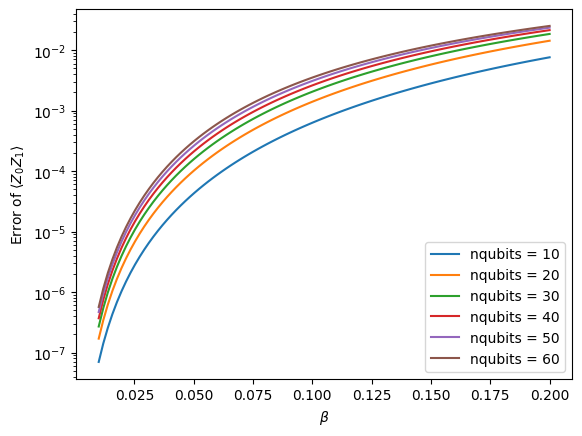

In [15]:
nqubits = [10, 20, 30, 40, 50, 60]
plt.figure()
Jx = 1.0
Jy = 1.0
h = 0.0
for nqubits in nqubits:

    beta = np.linspace(0.01, 0.2, 100)

    expectationExact = np.zeros(len(beta))
    expectationApprox = np.zeros(len(beta))
    M = jordan_wigner_tfim(nqubits, Jx, Jy, h)
    eigvals, eigvecs = np.linalg.eigh(M)
    for i in range(len(beta)):
        expectationExact[i] = zz_correlation(M, beta[i], 5, 6)
        expectationApprox[i] = (-beta[i]**2)/(1+ beta[i]**2*(nqubits-1))

    plt.plot(beta, np.abs(expectationExact-expectationApprox), label = f'nqubits = {nqubits}')
    plt.xlabel(r'$\beta$')
    plt.ylabel(r'Error of $\langle Z_{0} Z_{1} \rangle$')
    plt.yscale('log')
plt.legend()